In [29]:
# Configuração para não exibir os warnings
import warnings

warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import (
    train_test_split,
)  # para particionar em bases de treino e teste (holdout)
from sklearn.model_selection import KFold  # para preparar os folds da validação cruzada
from sklearn.model_selection import cross_val_score  # para executar a validação cruzada
from sklearn.metrics import accuracy_score  # para a exibição da acurácia do modelo

from sklearn.neighbors import KNeighborsClassifier  # algoritmo KNN
from sklearn.tree import DecisionTreeClassifier  # algoritmo Árvore de Classificação
from sklearn.naive_bayes import GaussianNB  # algoritmo Naive Bayes
from sklearn.svm import SVC  # algoritmo SVM

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

In [30]:
# Fonte: https://www.kaggle.com/datasets/khwaishsaxena/lung-cancer-dataset

import os

data_path = "../dados/lung_cancer.csv"
url = "https://raw.githubusercontent.com/rogerioferreira/MVP-Machine_Learnin-PUC-RIO/refs/heads/main/dados/lung_cancer.csv"

if os.path.exists(data_path):
    # caraga do dataset localmente, caso exista
    data = pd.read_csv(data_path)
else:
    # caraga do dataset pelo Git Hub
    data = pd.read_csv(url)


data.drop(
    columns=["id", "country"], inplace=True
)  # exclusão da colinas id e country por não serem relevantes para a análise
data.drop(
    columns=["diagnosis_date", "end_treatment_date"], inplace=True
)  # exclusão das data por não serem relevantes em novos casos

In [31]:
data.head()

,age,gender,cancer_stage,family_history,smoking_status,bmi,cholesterol_level,hypertension,asthma,cirrhosis,other_cancer,treatment_type,survived
0,64.0,Male,Stage I,Yes,Passive Smoker,29.4,199,0,0,1,0,Chemotherapy,0
1,50.0,Female,Stage III,Yes,Passive Smoker,41.2,280,1,1,0,0,Surgery,1
2,65.0,Female,Stage III,Yes,Former Smoker,44.0,268,1,1,0,0,Combined,0
3,51.0,Female,Stage I,No,Passive Smoker,43.0,241,1,1,0,0,Chemotherapy,0
4,37.0,Male,Stage I,No,Passive Smoker,19.7,178,0,0,0,0,Combined,0


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    Normalizer,
)

# Instanciando o encoder
# handle_unknown='ignore' evita erro se uma categoria nova aparecer no futuro
# sparse_output=False retorna uma matriz densa ao invés de esparsa
# encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop="first")
encoded_features = encoder.fit_transform(
    data[
        ["gender", "cancer_stage", "family_history", "smoking_status", "treatment_type"]
    ]
)
encoded_df = pd.DataFrame(
    encoded_features,
    columns=encoder.get_feature_names_out(
        ["gender", "cancer_stage", "family_history", "smoking_status", "treatment_type"]
    ),
)
data.drop(
    columns=[
        "gender",
        "cancer_stage",
        "family_history",
        "smoking_status",
        "treatment_type",
    ],
    inplace=True,
)
data_encoded = pd.concat([encoded_df, data], axis=1)


# Instanciando o StandardScaler / Normalizer
scaler = Normalizer()
scaled_features = scaler.fit_transform(
    data_encoded[["age", "bmi", "cholesterol_level"]]
)
scaled_df = pd.DataFrame(
    scaled_features,
    columns=scaler.get_feature_names_out(["age", "bmi", "cholesterol_level"]),
)

data_encoded.drop(
    columns=["age", "bmi", "cholesterol_level"], inplace=True
)  # exclusão das colunas não normalizadas
data_scaled = pd.concat([scaled_df, data_encoded], axis=1)


# conversão das features int64 para float64
data_scaled[["hypertension", "asthma", "cirrhosis", "other_cancer"]] = data_scaled[
    ["hypertension", "asthma", "cirrhosis", "other_cancer"]
].astype("float64")

In [33]:
data_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 890000 entries, 0 to 889999
Data columns (total 19 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   age                            890000 non-null  float64
 1   bmi                            890000 non-null  float64
 2   cholesterol_level              890000 non-null  float64
 3   gender_Male                    890000 non-null  float64
 4   cancer_stage_Stage II          890000 non-null  float64
 5   cancer_stage_Stage III         890000 non-null  float64
 6   cancer_stage_Stage IV          890000 non-null  float64
 7   family_history_Yes             890000 non-null  float64
 8   smoking_status_Former Smoker   890000 non-null  float64
 9   smoking_status_Never Smoked    890000 non-null  float64
 10  smoking_status_Passive Smoker  890000 non-null  float64
 11  treatment_type_Combined        890000 non-null  float64
 12  treatment_type_Radiation      

In [34]:
# Preparação dos dados

# Separação em bases de treino e teste (holdout)
array = data_scaled.values
X = array[:, 0:18]  # atributos
y = array[:, 18]  # classe (target)

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

# Definindo uma seed global para esta célula de código
np.random.seed(7)

# Treinar um Random Forest para obter a importância das features
model_rf = RandomForestClassifier()
model_rf.fit(X, y)

# Selecionar features com importância acima da média
sfm = SelectFromModel(model_rf, prefit=True, max_features=4)
X_selected_rf = sfm.transform(X)

print(f"Forma após a seleção de features com Random Forest: {X_selected_rf.shape}")

Forma após a seleção de features com Random Forest: (890000, 3)


In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    X_selected_rf, y, test_size=0.20, random_state=7
)  # faz a divisão

# Criando os folds para a validação cruzada
num_particoes = 3  # número de folds da validação cruzada (3, 5, 10)
kfold = KFold(
    n_splits=num_particoes, shuffle=True, random_state=7
)  # faz o particionamento em K folds

KNN: 0.737743 (0.000332)
CART: 0.680051 (0.000305)
NB: 0.779611 (0.000529)
ADC: 0.779611 (0.000529)
RFC: 0.714604 (0.000283)
ETC: 0.709690 (0.000362)


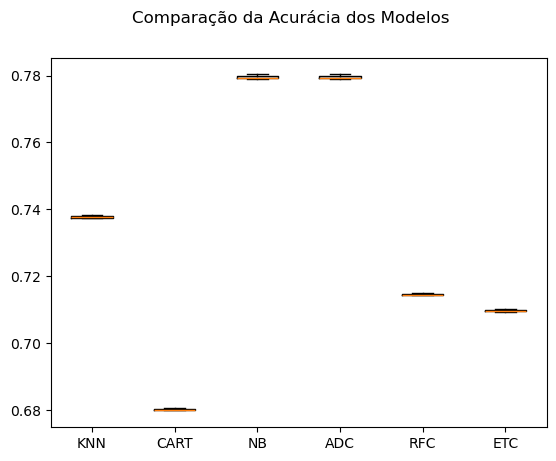

In [37]:
# Modelagem

# Definindo uma seed global para esta célula de código
np.random.seed(7)

# Listas para armazenar os modelos, os resultados e os nomes dos modelos
models = []
results = []
names = []

# Preparando os modelos e adicionando-os em uma lista
models.append(("KNN", KNeighborsClassifier()))
models.append(("CART", DecisionTreeClassifier()))
models.append(("NB", GaussianNB()))
# models.append(('SVM', SVC())) # modelo suspenso em virtude do tempo de processamento
models.append(("ADC", AdaBoostClassifier()))
models.append(("RFC", RandomForestClassifier()))
models.append(("ETC", ExtraTreesClassifier()))

# Avaliando um modelo por vez
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring="accuracy")
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (
        name,
        cv_results.mean(),
        cv_results.std(),
    )  # média e desvio padrão dos 10 resultados da validação cruzada
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure()
fig.suptitle("Comparação da Acurácia dos Modelos")
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()